In [1]:
cd "drive/MyDrive/model inversion(lenet)"

/content/drive/MyDrive/model inversion(lenet)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Extractor(nn.Module):

    def __init__(self):
        super(Extractor, self).__init__()
        self.extractor = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.AvgPool2d(2, 2),
            nn.Sigmoid(),
            nn.Conv2d(6, 16, 5),
            nn.AvgPool2d(2, 2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.extractor(x)
        return x

    
class Classifier(nn.Module):

    def __init__(self, num_classes=10):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.classifier(x)
        return x


class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(100 + 10, 512, 2, 1, 0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, 2, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 2, 1, 0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 16, 2, 1, 0),
            nn.Sigmoid(),
        )
        self.apply(weights_init)
        
    def forward(self, z, y):
        y = F.one_hot(y, 10)
        y = y.unsqueeze(-1).unsqueeze(-1)
        feat = torch.cat([z, y], 1)
        feat = self.generator(feat)
        return feat
    
    
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(16 + 10, 128, 2, 1, 0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 256, 2, 1, 0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 512, 2, 1, 0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(512, 1, 2, 1, 0),
            nn.Sigmoid(),
        )
        self.apply(weights_init)
        
    def forward(self, feat, y):
        y = F.one_hot(y, 10)
        y = y.unsqueeze(-1).unsqueeze(-1)
        y = y.expand(y.size(0), 10, 5, 5)
        feat = torch.cat([feat, y], 1)
        feat = self.discriminator(feat)
        feat = feat.squeeze(-1).squeeze(-1)
        return feat

In [3]:
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torchvision.datasets as datasets
import numpy as np

transform=transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

usps_trainset = datasets.USPS(root='./data', train=True, download=True, transform=transform)
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

size = len(usps_trainset)
index = np.arange(size)
client_trainset = Subset(usps_trainset, index[:2000])

client_trainloader = DataLoader(client_trainset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

In [18]:
import matplotlib.pyplot as plt  

def get_params(net, modules):
    params = []
    for module in modules:
        params.append({"params": net[module].parameters()})
    return params

def frozen_net(net, modules, frozen):
    for module in modules:
        for param in net[module].parameters():
            param.requires_grad = not frozen
        if frozen:
            net[module].eval()
        else:
            net[module].train()

def total_variation_loss(image):
    bs, c, h, w = image.size()
    tv_h = torch.pow(image[:,:,1:,:] - image[:,:,:-1,:], 2).sum()
    tv_w = torch.pow(image[:,:,:,1:] - image[:,:,:,:-1], 2).sum()
    return (tv_h + tv_w) / (bs * c * h * w)


def l2_loss(image):
    bs, c, h, w = image.size()
    l2 = torch.pow((image+1)/2, 2).sum()
    return l2 / (bs * c * h * w)



def show_image(image):
    image = image[0][0]  # [bs, 1, 32, 32] -> [32, 32]
    # image = image.permute(1, 2, 0)
    image = image.cpu().detach().numpy()
    image = (image+1)/2  # [-1,1] -> [0,1]
    plt.imshow(image, cmap='gray')


def cal_psnr(real_image, inversion_image):
    mse = ((real_image - inversion_image) ** 2).mean()
    mse = mse.cpu().detach().numpy()
    psnr = 10 * np.log10(4/mse)
    return psnr

**客户端的真实feature**

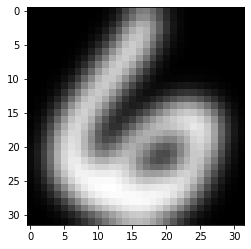

In [19]:
net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/client_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

iteration = iter(client_trainloader)

# 图片和标签（全局变量，不要覆盖）
image, label = next(iteration)

# 真实特征（全局变量，不要覆盖）
real_feature = net["extractor"](image).detach()

show_image(image)

**定义model inversion函数**

In [20]:
def model_inversion(net, feature, lambda_tv, lambda_l2):
    x = torch.zeros((1, 1, 32, 32))
    x.requires_grad = True
    x_optimizer = optim.Adam(params=[x], lr=1e-3)

    feature_mses, image_tvs, image_l2s, image_mses = [], [], [], []
    epoch, prev_image_mse = 0, 4.
    converge_flag = False

    while True:
        x_optimizer.zero_grad()
        inversion_feature = net["extractor"](x)
        feature_mse = ((feature - inversion_feature) ** 2).sum()
        image_tv = lambda_tv * total_variation_loss(x)
        image_l2 = lambda_l2 * l2_loss(x)
        loss = feature_mse + image_tv + image_l2
        loss.backward()
        x_optimizer.step()

        with torch.no_grad():
            image_mse = ((image - x) ** 2).mean()

        feature_mses.append(feature_mse.item())
        image_tvs.append(image_tv.item())
        image_l2s.append(image_l2.item())
        image_mses.append(image_mse.item())
        
        if epoch%1000 == 0:
            print("epoch:%4d, feature_mse:%2.6f, image_tv:%2.6f, image_l2:%2.6f, image_mse:%2.6f"
                %(epoch, np.mean(feature_mses), np.mean(image_tvs), np.mean(image_l2s), np.mean(image_mses)))
            
            # 收敛条件：image_mse减少量小于1e-6
            if prev_image_mse - np.mean(image_mses) < 1e-6:
                converge_flag = True
            else:
                prev_image_mse = np.mean(image_mses)
            feature_mses, image_tvs, image_mses = [], [], []

        if converge_flag:
            break
        epoch += 1
    
    # 返回反推的图片
    return x

epoch:   0, feature_mse:52.575859, image_tv:0.000000, image_l2:0.000002, image_mse:0.511037
epoch:1000, feature_mse:13.178490, image_tv:0.000001, image_l2:0.000002, image_mse:0.338444
epoch:2000, feature_mse:0.285435, image_tv:0.000002, image_l2:0.000002, image_mse:0.257446
epoch:3000, feature_mse:0.043392, image_tv:0.000002, image_l2:0.000003, image_mse:0.236247
epoch:4000, feature_mse:0.013213, image_tv:0.000003, image_l2:0.000003, image_mse:0.223693
epoch:5000, feature_mse:0.006374, image_tv:0.000003, image_l2:0.000003, image_mse:0.213575
epoch:6000, feature_mse:0.003906, image_tv:0.000003, image_l2:0.000003, image_mse:0.205317
epoch:7000, feature_mse:0.002513, image_tv:0.000003, image_l2:0.000003, image_mse:0.199724
epoch:8000, feature_mse:0.001549, image_tv:0.000003, image_l2:0.000003, image_mse:0.195992
epoch:9000, feature_mse:0.000884, image_tv:0.000003, image_l2:0.000003, image_mse:0.193732
epoch:10000, feature_mse:0.000468, image_tv:0.000003, image_l2:0.000003, image_mse:0.192

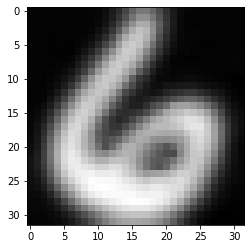

In [21]:
# 已知extractor，用真实feature攻击

net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/client_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, real_feature, lambda_tv=1e-5, lambda_l2=1e-5)
print("psnr:%2.6f"%cal_psnr(image, x))
show_image(x)

tensor(0.7243)
epoch:   0, feature_mse:51.488369, image_tv:0.000000, image_l2:2.500000, image_mse:0.510861
epoch:1000, feature_mse:12.019841, image_tv:0.234146, image_l2:2.085777, image_mse:0.233088
epoch:2000, feature_mse:0.650130, image_tv:0.295334, image_l2:1.917227, image_mse:0.063989
epoch:3000, feature_mse:0.467439, image_tv:0.278007, image_l2:1.842295, image_mse:0.040578
epoch:4000, feature_mse:0.439415, image_tv:0.273880, image_l2:1.800710, image_mse:0.036153
epoch:5000, feature_mse:0.432365, image_tv:0.274483, image_l2:1.774365, image_mse:0.035254
epoch:6000, feature_mse:0.430252, image_tv:0.276236, image_l2:1.756278, image_mse:0.035178
epoch:7000, feature_mse:0.429563, image_tv:0.277427, image_l2:1.743193, image_mse:0.035239
psnr:20.547593


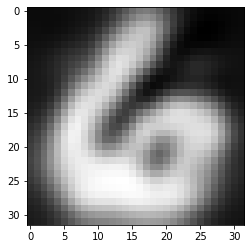

In [46]:
# 相同数据训练extractor，用真实feature攻击

net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_same_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

shadow_feature = net["extractor"](image).detach()
print( ((shadow_feature - real_feature) ** 2).sum() )

x = model_inversion(net, real_feature, lambda_tv=10, lambda_l2=10)
print("psnr:%2.6f"%cal_psnr(image, x))
show_image(x)

tensor(23.4673)
epoch:   0, feature_mse:51.893711, image_tv:0.000000, image_l2:12.500000, image_mse:0.510867
epoch:1000, feature_mse:27.202532, image_tv:0.606115, image_l2:9.348421, image_mse:0.240785
epoch:2000, feature_mse:20.201478, image_tv:1.062891, image_l2:8.396666, image_mse:0.118191
epoch:3000, feature_mse:19.476287, image_tv:1.316567, image_l2:8.017016, image_mse:0.110605
epoch:4000, feature_mse:19.286626, image_tv:1.412019, image_l2:7.827474, image_mse:0.111458
psnr:15.536126


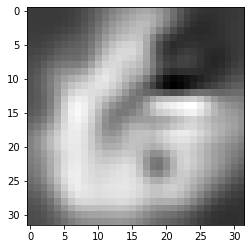

In [55]:
# 同分布数据训练extractor，用真实feature攻击

net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_iid_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

shadow_feature = net["extractor"](image).detach()
print( ((shadow_feature - real_feature) ** 2).sum() )

x = model_inversion(net, real_feature, lambda_tv=50, lambda_l2=50)
print("psnr:%2.6f"%cal_psnr(image, x))
show_image(x)

tensor(73.5863)
epoch:   0, feature_mse:64.754036, image_tv:0.000000, image_l2:12.500000, image_mse:0.511421
epoch:1000, feature_mse:42.965128, image_tv:0.551742, image_l2:9.256109, image_mse:0.394342
epoch:2000, feature_mse:36.453613, image_tv:1.530785, image_l2:8.105175, image_mse:0.312422
epoch:3000, feature_mse:34.916723, image_tv:2.286902, image_l2:7.604238, image_mse:0.323610
psnr:10.823997


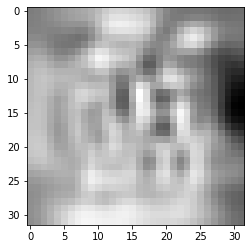

In [72]:
# 不同分布数据训练extractor，用真实feature攻击

net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_niid_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

shadow_feature = net["extractor"](image).detach()
print( ((shadow_feature - real_feature) ** 2).sum() )

x = model_inversion(net, real_feature, lambda_tv=50, lambda_l2=50)
print("psnr:%2.6f"%cal_psnr(image, x))
show_image(x)

In [60]:
# z 和 image 配对 (最小化fake feature和real feature的mse)

net = nn.ModuleDict()
net["generator"] = Generator()            
frozen_net(net, ["generator"], True)

G_checkpoint = torch.load("./checkpoint/client_generator.pkl", map_location=torch.device('cpu'))
net["generator"].load_state_dict(G_checkpoint)

# 优化z
z = torch.zeros((1, 100, 1, 1))
z.requires_grad = True
z_optimizer = optim.Adam(params=[z], lr=1e-3)

feature_mses = []
epoch, prev_loss = 0, 10000.
converge_flag = False
while True:
    z_optimizer.zero_grad()
    inversion_feature = net["generator"](z, label)
    feature_mse = ((real_feature - inversion_feature) ** 2).sum()
    feature_mse.backward()
    z_optimizer.step()

    feature_mses.append(feature_mse.item())

    if epoch%1000 == 0:
        print("epoch:%4d, feature_mse:%2.6f"%(epoch, np.mean(feature_mses)))
        if prev_loss - np.mean(feature_mses) < 1e-6:
            converge_flag = True
        else:
            prev_loss = np.mean(feature_mses)
        feature_mses = []

    if converge_flag:
        break
    epoch += 1

# 最接近真实feature的虚假feature（全局变量，不要覆盖）
fake_feature = net["generator"](z, label).detach()

epoch:   0, feature_mse:34.283352
epoch:1000, feature_mse:6.290771
epoch:2000, feature_mse:2.487619
epoch:3000, feature_mse:1.645013
epoch:4000, feature_mse:1.193951
epoch:5000, feature_mse:0.998691
epoch:6000, feature_mse:0.859905
epoch:7000, feature_mse:0.760917
epoch:8000, feature_mse:0.674596
epoch:9000, feature_mse:0.572580
epoch:10000, feature_mse:0.497065
epoch:11000, feature_mse:0.453752
epoch:12000, feature_mse:0.434555
epoch:13000, feature_mse:0.416159
epoch:14000, feature_mse:0.401901
epoch:15000, feature_mse:0.391682
epoch:16000, feature_mse:0.385638
epoch:17000, feature_mse:0.379028
epoch:18000, feature_mse:0.374865
epoch:19000, feature_mse:0.370127
epoch:20000, feature_mse:0.367239
epoch:21000, feature_mse:0.364605
epoch:22000, feature_mse:0.361165
epoch:23000, feature_mse:0.358422
epoch:24000, feature_mse:0.356116
epoch:25000, feature_mse:0.353189
epoch:26000, feature_mse:0.349529
epoch:27000, feature_mse:0.347112
epoch:28000, feature_mse:0.343429
epoch:29000, feature_ms

epoch:   0, feature_mse:51.439659, image_tv:0.000000, image_l2:2.500000, image_mse:0.510827
epoch:1000, feature_mse:13.017239, image_tv:0.276634, image_l2:2.093337, image_mse:0.228393
epoch:2000, feature_mse:0.612962, image_tv:0.368467, image_l2:1.908189, image_mse:0.057357
epoch:3000, feature_mse:0.405648, image_tv:0.347146, image_l2:1.826829, image_mse:0.036744
epoch:4000, feature_mse:0.379061, image_tv:0.338374, image_l2:1.782230, image_mse:0.033577
epoch:5000, feature_mse:0.373046, image_tv:0.336146, image_l2:1.754369, image_mse:0.033200
epoch:6000, feature_mse:0.371456, image_tv:0.336375, image_l2:1.735478, image_mse:0.033352
psnr:20.778546


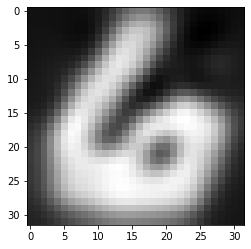

In [68]:
# 已知extractor，用虚假feature攻击

net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/client_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, fake_feature, lambda_tv=10, lambda_l2=10)
print("psnr:%2.6f"%cal_psnr(image, x))
show_image(x)

epoch:   0, feature_mse:50.430271, image_tv:0.000000, image_l2:2.500000, image_mse:0.510875
epoch:1000, feature_mse:11.850204, image_tv:0.231229, image_l2:2.078499, image_mse:0.234499
epoch:2000, feature_mse:0.883765, image_tv:0.286427, image_l2:1.906169, image_mse:0.067536
epoch:3000, feature_mse:0.727184, image_tv:0.269339, image_l2:1.828834, image_mse:0.044741
epoch:4000, feature_mse:0.702814, image_tv:0.266652, image_l2:1.785848, image_mse:0.040525
epoch:5000, feature_mse:0.695373, image_tv:0.268460, image_l2:1.758712, image_mse:0.039783
epoch:6000, feature_mse:0.692477, image_tv:0.270999, image_l2:1.740155, image_mse:0.039788
psnr:20.018253


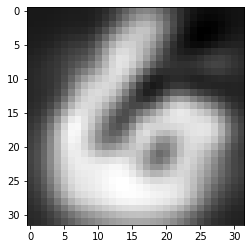

In [67]:
# 相同数据训练extractor，用虚假feature攻击

net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_same_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, fake_feature, lambda_tv=10, lambda_l2=10)
print("psnr:%2.6f"%cal_psnr(image, x))
show_image(x)

epoch:   0, feature_mse:51.601650, image_tv:0.000000, image_l2:12.500000, image_mse:0.510881
epoch:1000, feature_mse:27.369651, image_tv:0.604441, image_l2:9.278686, image_mse:0.243026
epoch:2000, feature_mse:20.496943, image_tv:1.072585, image_l2:8.314328, image_mse:0.122519
epoch:3000, feature_mse:19.780538, image_tv:1.325037, image_l2:7.933290, image_mse:0.115463
epoch:4000, feature_mse:19.605660, image_tv:1.414425, image_l2:7.743107, image_mse:0.116235
psnr:15.357020


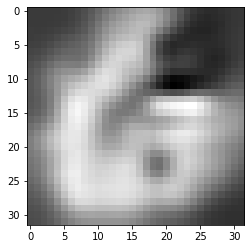

In [70]:
# 同分布数据训练extractor，用虚假feature攻击

net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_iid_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, fake_feature, lambda_tv=50, lambda_l2=50)
print("psnr:%2.6f"%cal_psnr(image, x))
show_image(x)

epoch:   0, feature_mse:63.701435, image_tv:0.000000, image_l2:12.500000, image_mse:0.511426
epoch:1000, feature_mse:41.790799, image_tv:0.551524, image_l2:9.309408, image_mse:0.392953
epoch:2000, feature_mse:35.369261, image_tv:1.537210, image_l2:8.152292, image_mse:0.309085
epoch:3000, feature_mse:33.994795, image_tv:2.232737, image_l2:7.652350, image_mse:0.318533
psnr:10.897114


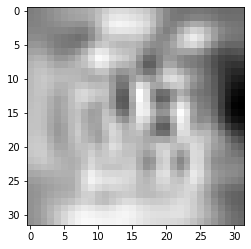

In [71]:
# 不同分布数据训练extractor，用虚假feature攻击

net = nn.ModuleDict()
net["extractor"] = Extractor()              
frozen_net(net, ["extractor"], True)

E_checkpoint = torch.load("./checkpoint/server_niid_extractor.pkl", map_location=torch.device('cpu'))
net["extractor"].load_state_dict(E_checkpoint)

x = model_inversion(net, fake_feature, lambda_tv=50, lambda_l2=50)
print("psnr:%2.6f"%cal_psnr(image, x))
show_image(x)